<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


## Tool to add CCF info to Units dataframe, including:
- Cortical layer
- Relative Cortical Depth
- Full CCF structure names

Running this will download several files to your working directory:
1) manifest.json: the manifest for the ccf reference space cache
2) structures.json: structure tree for CCF
3) laplacian_10.nrrd: cortical streamlines. These give the depth of cortical units along an axis that is normal to the cortical surface.
4) annotation (directory): this will contain the annotation nrrd file storing the structure IDs for every voxel in the CCF.

Together, these take up ~500 MB of space (dominated by annotation--30MB; and laplacian--440 MB)

In [17]:
from allensdk.core.reference_space_cache import ReferenceSpaceCache
import re
import nrrd
import os
import requests

class VBN_CCF:

    def __init__(self, manifest_path='manifest.json', resolution=10):
        reference_space_key = 'annotation/ccf_2017'
        self.resolution = resolution
        self.rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=manifest_path)
        # ID 1 is the adult mouse structure graph
        self.tree = self.rspc.get_structure_tree(structure_graph_id=1) 
        self._annotation = None
        self._streamlines = None
        self._manifest_directory = os.path.dirname(manifest_path)


    @property
    def annotation(self):
        if self._annotation is None:
            self._annotation, meta = self.rspc.get_annotation_volume()
        return self._annotation

    
    @property
    def streamlines(self):
        if self._streamlines is None:
            streamlines_path = os.path.join(self._manifest_directory, 'laplacian_10.nrrd')
            #First check to see if the streamlines have already been downloaded
            if os.path.exists(streamlines_path):
                self._streamlines, header = nrrd.read(streamlines_path)
            
            #Otherwise download it and write it to file
            else:
                s = requests.get('https://www.dropbox.com/sh/7me5sdmyt5wcxwu/AACFY9PQ6c79AiTsP8naYZUoa/laplacian_10.nrrd?dl=1')
                with open(streamlines_path, 'wb') as f:
                    f.write(bytes(s.content))
                self._streamlines, header = nrrd.read(streamlines_path)
                
        return self._streamlines


    def get_structure_by_acronym(self, acronym):
        try:
            structure = self.tree.get_structures_by_acronym([acronym])
        except KeyError:
            print(f'Could not find structure corresponding to acronym {acronym}')
            structure = [{}]
        return structure


    def get_structure_name_by_acronym(self, acronym):
        structure = self.get_structure_by_acronym(acronym)[0]
        return structure.get('name', None)

    
    def get_structure_id_by_coordinate(self, ap_coord, dv_coord, lr_coord):

        volume_coords = [int(coord/self.resolution) for coord in [ap_coord, dv_coord, lr_coord]]
        shape = self.annotation.shape
        if any([(v<0 or v>=s) for v,s in zip(volume_coords,shape)]):
            print(f'Coordinate {[ap_coord, dv_coord, lr_coord]} is outside ccf')
            id = 0
        else:
            id = self.annotation[volume_coords[0], volume_coords[1], volume_coords[2]]
        return id


    def get_structure_by_id(self, id):
        if id == 0:
            structure = [{'name': 'outside_brain',
                        'acronym': 'outside_brain'}]
        else:
            structure = self.tree.get_structures_by_id([id])
        return structure


    def get_structure_by_coordinate(self, ap_coord, dv_coord, lr_coord):
        try:
            id = self.get_structure_id_by_coordinate(ap_coord, dv_coord, lr_coord)
            structure = self.get_structure_by_id(id)
        except Exception as e:
            print(f'Could not get structure corresponding to id: {id} due to error {e}')
            structure = [{}]
        return structure


    def get_structure_acronym_by_coordinate(self, ap_coord, dv_coord, lr_coord):

        structure = self.get_structure_by_coordinate(ap_coord, dv_coord, lr_coord)[0]
        return structure.get('acronym', None)

    
    def get_cortical_layer_by_coordinate(self, ap_coord, dv_coord, lr_coord):
        
        acronym = self.get_structure_acronym_by_coordinate(ap_coord, dv_coord, lr_coord)
        return self.get_cortical_layer_name_by_acronym(acronym)
        
        
    def get_cortical_layer_name_by_acronym(self, acronym):

        if acronym in ['CA1', 'CA2', 'CA3']:
            return ''
    
        try:
            first_num = re.findall(r'\d+', acronym)[0]
            first_num_ind = acronym.find(first_num)
            if first_num_ind<0:
                return ''
            
            layer = acronym[first_num_ind:]
            return layer

        except IndexError:
            return ''
    

    def get_cortical_depth_by_coordinate(self, ap_coord, dv_coord, lr_coord):
        volume_coords = [int(coord/10) for coord in [ap_coord, dv_coord, lr_coord]]
        try:
            cortical_depth = self.streamlines[volume_coords[0], volume_coords[1], volume_coords[2]]
        except IndexError as e:
            print(f'Coordinate {[ap_coord, dv_coord, lr_coord]} is outside of CCF')
            cortical_depth = 0
        return cortical_depth

In [18]:
#instatiate tool: this will automatically download the small files (manifest and structure jsons)
c = VBN_CCF()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Get data from one example VBN session

In [19]:
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)

%matplotlib inline

In [5]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

In [6]:
# this path should point to the location of the dataset on your platform
cache_dir = os.path.join(data_root, data_dirname)

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

In [7]:
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

/srv/conda/envs/notebook/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Merge channels table info into the units table

In [8]:
units = session.get_units()
channels = session.get_channels()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Get full structure names for each unit

In [ ]:
full_names = units.apply(lambda row: c.get_structure_name_by_acronym(row['structure_acronym']), axis=1)
units['full_structure_names'] = full_names

In [25]:
units['full_structure_names']

id
1061853767    Anterior pretectal nucleus
1061853941      Anteromedial visual area
1061853761    Anterior pretectal nucleus
1061853892      Anteromedial visual area
1061853891      Anteromedial visual area
                         ...            
1061855121    Anterior pretectal nucleus
1061855215                     Field CA1
1061855202                 Dentate gyrus
1061855346     Rostrolateral visual area
1061855342     Rostrolateral visual area
Name: full_structure_names, Length: 1543, dtype: object

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Get relative cortical depth for all units
This metric will be '0' for units outside of cortex and range from (0, 1] for units inside cortex with numbers getting larger as you travel from pia to white matter.

In [20]:
cortical_depth = units.apply(lambda row: c.get_cortical_depth_by_coordinate(row['anterior_posterior_ccf_coordinate'],
                                                                            row['dorsal_ventral_ccf_coordinate'],
                                                                            row['left_right_ccf_coordinate']), axis=1)

In [73]:
cortical_depth.max()

0.989447

In [22]:
units['cortical_depth'] = cortical_depth

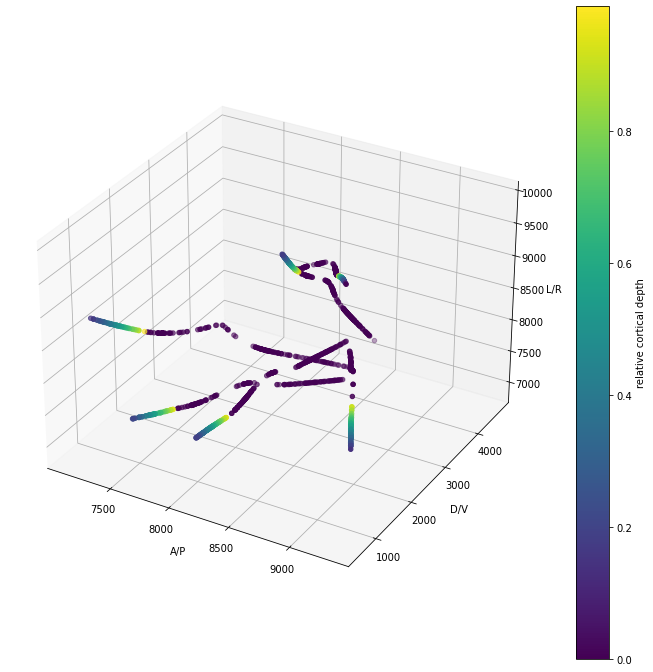

In [71]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

s = ax.scatter(units['anterior_posterior_ccf_coordinate'],
           units['dorsal_ventral_ccf_coordinate'],
           units['left_right_ccf_coordinate'],
           c = units['cortical_depth'])
ax.set_xlabel('A/P')
ax.set_ylabel('D/V')
ax.set_zlabel('L/R')


plt.colorbar(s, label='relative cortical depth')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Get cortical layer assignments for all units
This will extract the layer assignments from the CCF. Keep in mind that these are rough assigments and should be interpreted with a grain of salt.

In [26]:
cortical_layer = units.apply(lambda row: c.get_cortical_layer_by_coordinate(row['anterior_posterior_ccf_coordinate'],
                                                                            row['dorsal_ventral_ccf_coordinate'],
                                                                            row['left_right_ccf_coordinate']), axis=1)

In [27]:
units['cortical_layer'] = cortical_layer

id
1061853767       
1061853941    2/3
1061853761       
1061853892     6a
1061853891     6a
             ... 
1061855121       
1061855215       
1061855202       
1061855346    2/3
1061855342    2/3
Name: cortical_layer, Length: 1543, dtype: object

In [53]:
layer_names, layer_assignment_inds = np.unique(units['cortical_layer'], return_inverse=True)
layer_names[layer_names==''] = 'outside cortex'

[Text(1, 0.5, 'outside cortex'),
 Text(1, 1.3333333333333335, '1'),
 Text(1, 2.166666666666667, '2/3'),
 Text(1, 3.0, '4'),
 Text(1, 3.8333333333333335, '5'),
 Text(1, 4.666666666666667, '6a'),
 Text(1, 5.5, '6b')]

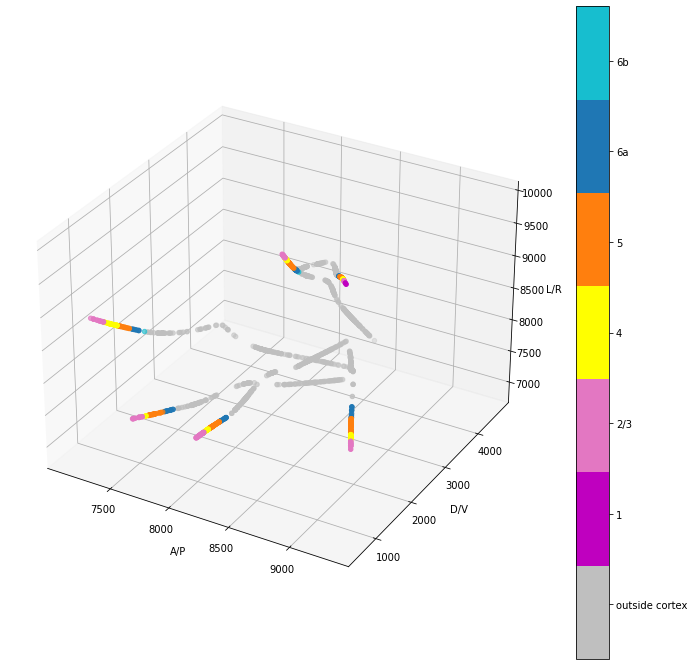

In [72]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
layer_cmap = ListedColormap(['0.75', 'm', 'tab:pink', 'yellow', 'tab:orange', 'tab:blue', 'tab:cyan'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

s = ax.scatter(units['anterior_posterior_ccf_coordinate'],
           units['dorsal_ventral_ccf_coordinate'],
           units['left_right_ccf_coordinate'],
           c = layer_assignment_inds,
           cmap=layer_cmap)

ax.set_xlabel('A/P')
ax.set_ylabel('D/V')
ax.set_zlabel('L/R')

cbar = plt.colorbar(s, ticks=np.linspace(0.5, 5.5, len(layer_names)))
cbar.ax.set_yticklabels(layer_names)  # vertically oriented colorbar